## Setup

In [1]:
import os
import pathlib
from random import choice

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers # type: ignore
from tensorflow.keras import models # type: ignore
from IPython import display
tf.keras.layers

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import wandb

sweep_config = {
    "method": "grid",  
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {
            "values": [0.001] 
        },
        "dropout_rate": {
            "values": [0.3]
        },
        "epochs": {
            "values": [10]
        },
        "activation_function": {
            "values": ["leaky_relu"]
            # "values": ["sigmoid", "tanh", "leaky_relu"]  # Different activation functions to test
        }
    }
}


sweep_id = wandb.sweep(sweep_config, project="ml_project", entity="anastasiiakuvshynova-politechnika-warszawska")

2025-01-29 17:41:48.590062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738168908.603136  123527 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738168908.607306  123527 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 17:41:48.621249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create sweep with ID: mmxofumz
Sweep URL: https://wandb.ai/anastasiiakuvshynova-politechnika-warszawska/ml_project/sweeps/mmxofumz


### Data Loading and Preprocessing

In [2]:
DATASET_PATH = 'processed_train'
#DATASET_PATH = 'train/noise_train/processed_train'
# DATASET_PATH = 'train'
data_dir = pathlib.Path(DATASET_PATH)

TEST_PATH = 'test'
test_dir = pathlib.Path(TEST_PATH)

In [3]:
words = np.array(tf.io.gfile.listdir(str(data_dir)))
#words = np.delete(words, np.where(words == '_background_noise_'))
print('Words:', words)

Words: ['dog' 'down' 'tree' 'right' 'bed' 'up' 'one' 'six' 'yes' 'house' 'four'
 'stop' 'zero' 'on' 'left' 'five' 'seven' 'three' 'eight' 'sheila' 'cat'
 'two' 'off' 'marvin' 'nine' 'no' 'go' 'wow' 'bird' 'happy']


Loading data with audio_dataset_from_directory. The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

orig_label_names = np.array(train_ds.class_names)
print()
print("Label names:", orig_label_names)

Found 64721 files belonging to 30 classes.
Using 51777 files for training.
Using 12944 files for validation.


I0000 00:00:1738168920.873180  123527 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



Label names: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [5]:
submission_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=64,
    shuffle=False,
    class_names=None,
    output_sequence_length=16000)

Found 148539 files belonging to 1 classes.


#### Balancing the dataset

Lets plot bar chart of the current class distribution in train dataset.

2025-01-29 17:42:14.069829: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


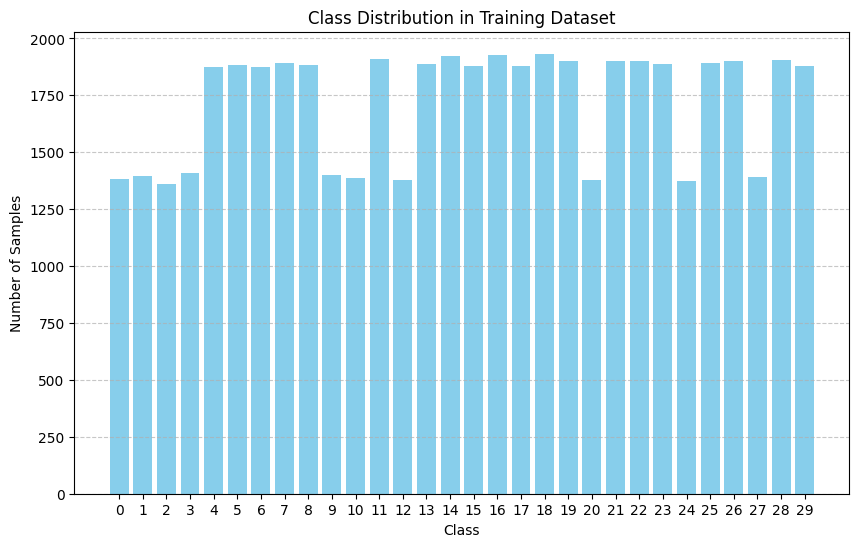

In [6]:
# Calculate and visualize class distribution
def get_class_distribution(dataset):
    """
    Returns the distribution of classes in the dataset.
    """
    class_counts = {}
    for audio, label in dataset.unbatch():
        label_value = label.numpy()
        class_counts[label_value] = class_counts.get(label_value, 0) + 1
    return class_counts

# Visualize class distribution for training data
train_class_counts = get_class_distribution(train_ds)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color="skyblue")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Dataset")
plt.xticks(list(train_class_counts.keys()))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Now, we will create a function to oversample the dataset to ensure all classes have at least  `target_count` samples.

In [7]:
def oversample_dataset(dataset, target_count):
    # Group samples by class
    class_samples = {}
    for audio_batch, label_batch in dataset:
        for audio, label in zip(audio_batch.numpy(), label_batch.numpy()):
            label_value = int(label)  # Convert label to a scalar integer
            if label_value not in class_samples:
                class_samples[label_value] = []
            class_samples[label_value].append((audio, label_value))

    # Oversample each class to match the target count
    balanced_samples = []
    for label_value, samples in class_samples.items():
        while len(samples) < target_count:
            samples.append(choice(samples))  # Randomly duplicate
        balanced_samples.extend(samples)

    # Convert back to TensorFlow dataset
    audio_data, labels = zip(*balanced_samples)
    balanced_dataset = tf.data.Dataset.from_tensor_slices((list(audio_data), list(labels)))

    # Shuffle and batch the dataset
    balanced_dataset = balanced_dataset.shuffle(10000).batch(64)
    return balanced_dataset

Next, we will rebalance the train dataset using oversampling technique.

In [8]:
# # Calculate class distribution before balancing
# train_class_counts = get_class_distribution(train_ds)
# print("Class distribution before balancing:", train_class_counts)

# # Oversample the training dataset
# max_class_count = max(train_class_counts.values())
# balanced_train_ds = oversample_dataset(train_ds, target_count=max_class_count)

# # Calculate class distribution after balancing
# balanced_class_counts = get_class_distribution(balanced_train_ds)
# print("Class distribution after balancing:", balanced_class_counts)

# # Plot the balanced class distribution
# plt.figure(figsize=(10, 6))
# plt.bar(balanced_class_counts.keys(), balanced_class_counts.values(), color="lightgreen")
# plt.xlabel("Class")
# plt.ylabel("Number of Samples")
# plt.title("Balanced Class Distribution in Training Dataset")
# plt.xticks(list(balanced_class_counts.keys()))
# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()

#### Relabling the classes & Reshaping the data

As mentioned in the task, there are only 12 possible labels for the Test set: yes, no, up, down, left, right, on, off, stop, go, silence, unknown. At this point for simplicity we will consider silent as unknown.

Changing lables to consider only words of interest:

In [9]:
label_names = np.asarray(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown'])
label_names_map = {label: i for i, label in enumerate(label_names)}

In [10]:
label_names_map

{np.str_('yes'): 0,
 np.str_('no'): 1,
 np.str_('up'): 2,
 np.str_('down'): 3,
 np.str_('left'): 4,
 np.str_('right'): 5,
 np.str_('on'): 6,
 np.str_('off'): 7,
 np.str_('stop'): 8,
 np.str_('go'): 9,
 np.str_('unknown'): 10}

In [11]:
# Function to map labels
def map_labels(labels):
    # 10 - unknown label
    return np.array([label_names_map.get(orig_label_names[label], 10) for label in labels], dtype=np.int64)

# Transform labels in train and validation datasets
def preprocess_dataset(dataset):
    def map_and_set_shape(x, y):
        # Apply mapping
        y = tf.numpy_function(map_labels, [y], tf.int64)
        # Explicitly set the shape of the labels to be scalar
        y.set_shape([None])  # [] means a scalar label
        return x, y

    return dataset.map(map_and_set_shape, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
# train_ds = preprocess_dataset(balanced_train_ds)
train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [13]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

This dataset only contains single channel audio, so the tf.squeeze function is used to drop the extra axis:

In [14]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

submission_ds = submission_ds.map(squeeze, tf.data.AUTOTUNE)

In [15]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

We will use test_ds to evaluate our model after training and submission_ds to predict the labels of the given test data.

Inspecting the shape of a single batch from the training dataset:

In [16]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2025-01-29 17:42:14.931098: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Plotting Audio Waveforms

In this section, we visualize the waveforms of selected audio samples from our training dataset. Waveforms represent the amplitude of the audio signal over time.

We will plot a grid of waveforms for a set of audio samples, each labeled with its corresponding class name.

In [17]:
label_names[[1,1,3,0]]

array(['no', 'no', 'down', 'yes'], dtype='<U7')

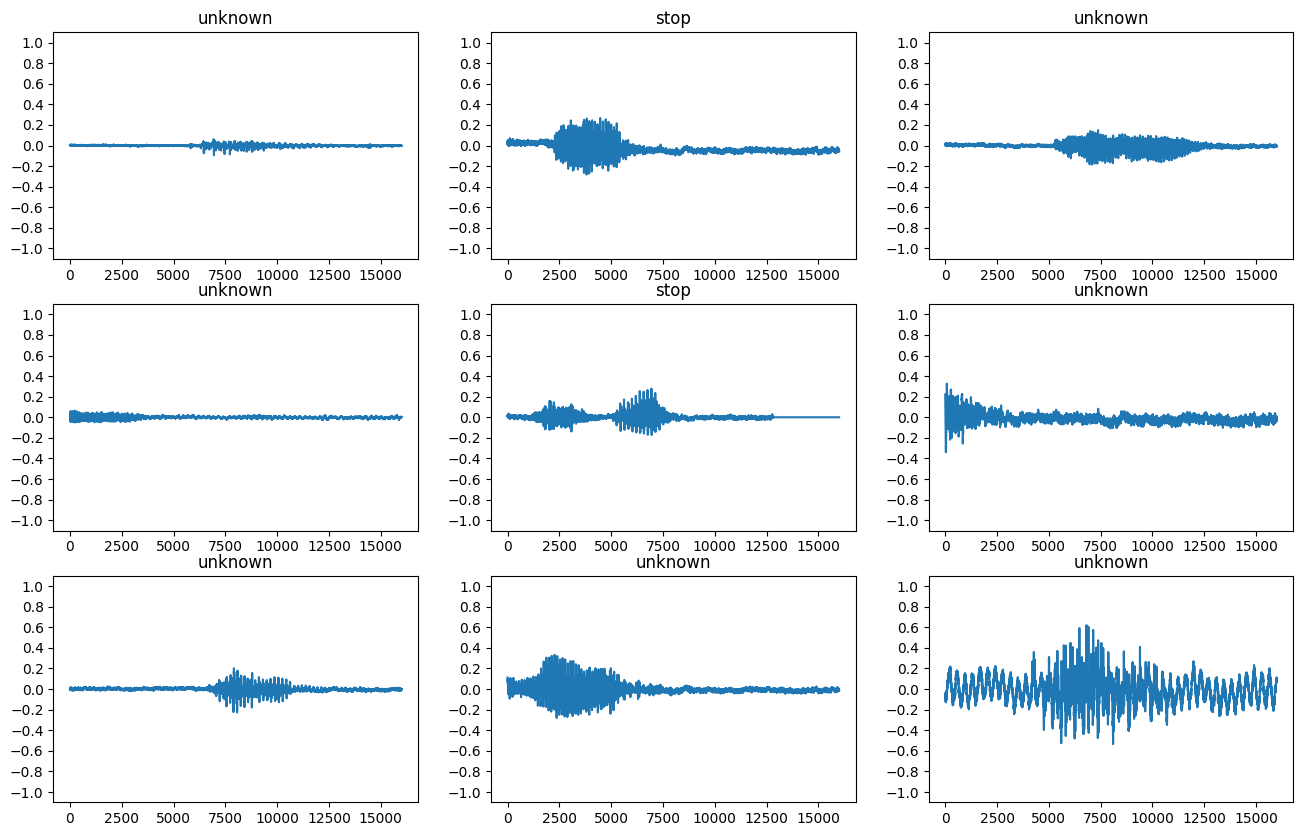

In [18]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

### Converting waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. We'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images.

In [19]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, to explore the data we print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [20]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, we define a function for displaying a spectrogram:

In [21]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

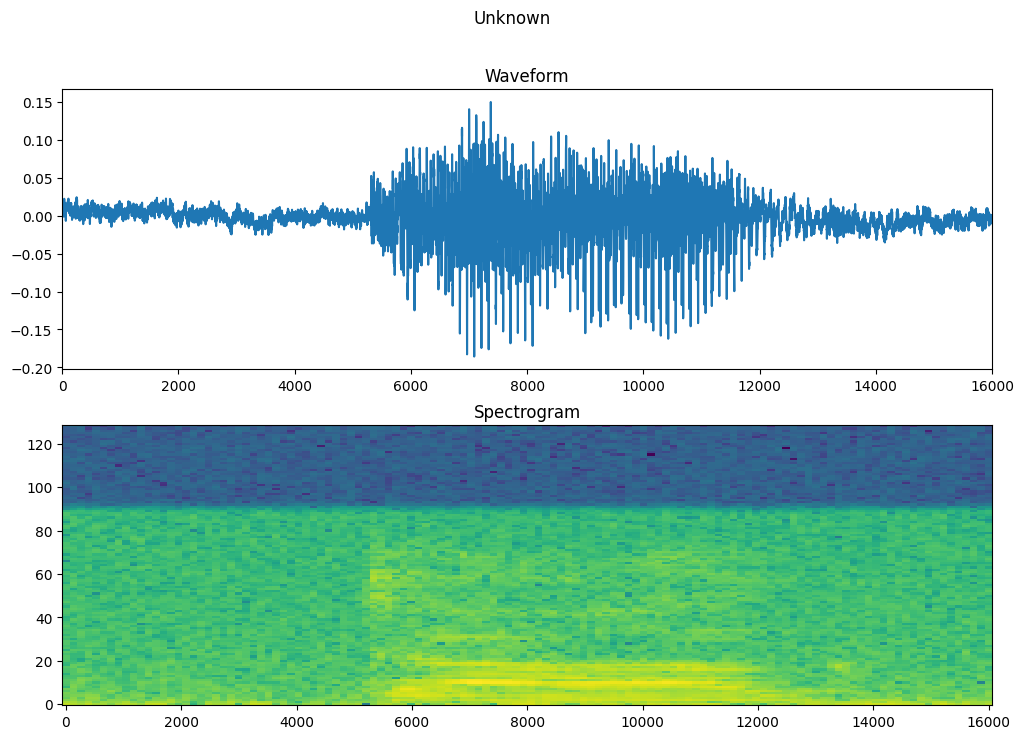

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Creation of spectrogram datasets from the audio datasets:

In [23]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
submission_spectrogram_ds = make_spec_ds(submission_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examination of the spectrograms for different examples of the dataset:

In [25]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

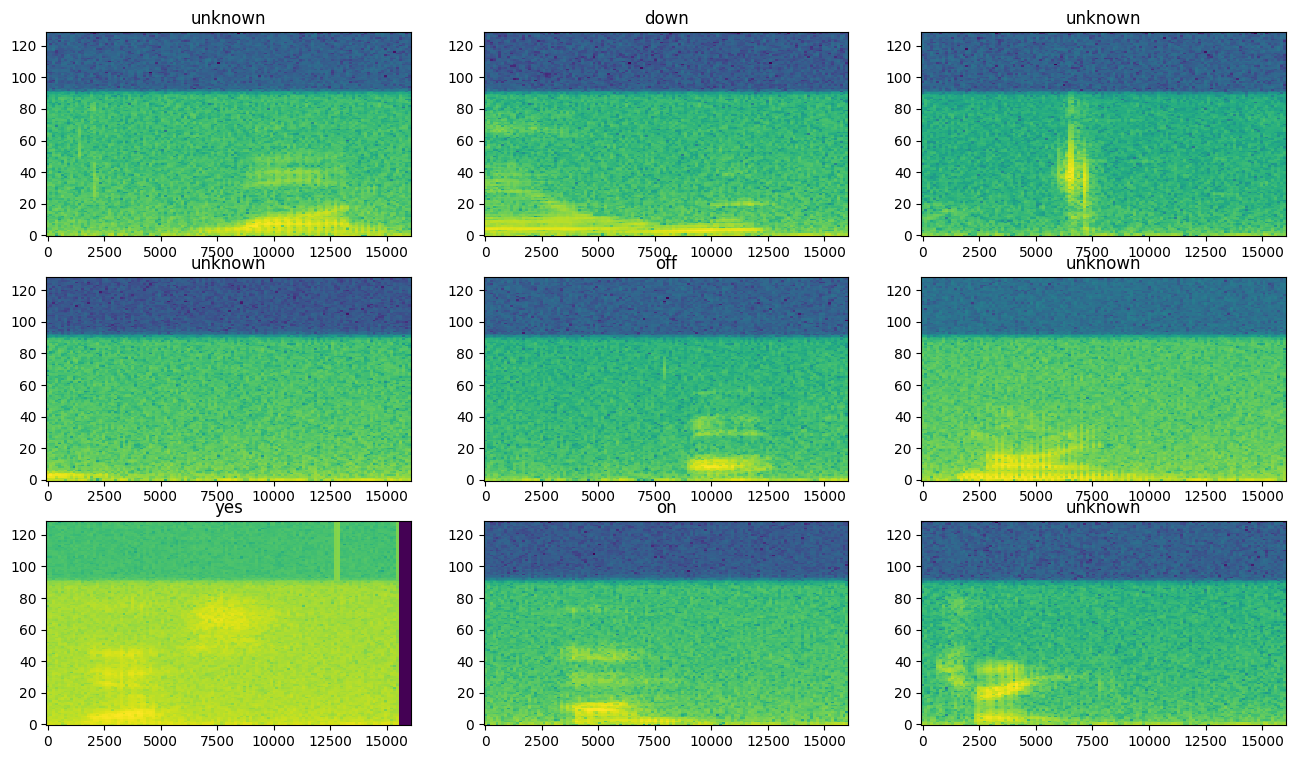

In [26]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Building and training the model

Adding Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [27]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
submission_spectrogram_ds = submission_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
print(f"Dataset length: {len(list(train_spectrogram_ds))}")

Dataset length: 810


Lets, use a simple convolutional neural network (CNN), since we have transformed the audio files into spectrogram images.

Our model will use the following Keras preprocessing layers:
* tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
* tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [28]:
DROPOUT = 0.25
num_labels = len(label_names)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
def build_simple_model(dropout_rate, activation_function):
  model = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      # Downsample the input.
      layers.Resizing(32, 32),
      # Normalize.
      norm_layer,
      layers.Conv2D(32, 3, activation=activation_function, padding='same'),
      layers.Conv2D(64, 3, activation=activation_function, padding='same'),
      layers.MaxPooling2D(),
      layers.Dropout(dropout_rate),
      layers.Flatten(),
      layers.Dense(128, activation=activation_function),
      layers.Dropout(dropout_rate),
      layers.Dense(num_labels),
  ])
  
  return model

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)


Input shape: (124, 129, 1)
Input shape: (124, 129, 1)


2025-01-29 17:42:26.055689: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
input_shape = example_spectrograms.shape[1:]

def build_complex_model(dropout_rate, activation):
    """
    Builds and returns a deep convolutional neural network (CNN) for audio classification.
    """
    model = tf.keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Convolutional block 1
        layers.Conv2D(32, (3, 3), activation=activation, padding='same', name='conv1'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Convolutional block 2
        layers.Conv2D(64, (3, 3), activation=activation, padding='same', name='conv2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Convolutional block 3
        layers.Conv2D(128, (3, 3), activation=activation, padding='same', name='conv3'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Dropout to prevent overfitting
        layers.Dropout(dropout_rate),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(len(label_names), activation=activation)  # Adjust output size to match the number of classes
    ])
    
    return model

Define a custom wandb callback class to log the trainin data: Training the model over 7 epochs:

In [30]:
class CustomWandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
            "train_loss": logs.get("loss"),
            "train_accuracy": logs.get("accuracy"),
            "val_loss": logs.get("val_loss"),
            "val_accuracy": logs.get("val_accuracy")
        })


Declare the lists that will store the histories and models of different iterations:

In [31]:
histories = []
created_models = []

Train the model for different parameters:

Or as one function:

In [32]:
# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,  # Starting LR
    decay_steps=10000,
    decay_rate=0.9
)

# Use the learning rate schedule in the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [33]:
def train():
    with wandb.init() as run:
        config = wandb.config
        run.name = f"dp_complex_{config.dropout_rate}_lr_{config.learning_rate}_af_{config.activation_function}_Adam_epochs_{config.epochs}_noise_set"  # Example: "dp_0.50_lr_0.003_epochs_5"
        run.save()  # Ensure the name is saved in the WandB dashboard

        model = build_complex_model(config.dropout_rate, config.activation_function)
        
        # optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
        # optimizer=tf.keras.optimizers.SGD(learning_rate=config.learning_rate)
        # optimizer=tf.keras.optimizers.RMSprop(learning_rate=config.learning_rate)

        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        history = model.fit(
            train_spectrogram_ds,
            validation_data=val_spectrogram_ds,
            epochs=config.epochs,
            callbacks=[
                # tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
                CustomWandbCallback()  # Add this to log metrics to WandB
            ],
        )
        histories.append(history)
        created_models.append(model)


wandb.agent(sweep_id, train)

wandb: Agent Starting Run: d1ni5l6s with config:
wandb: 	activation_function: leaky_relu
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: Currently logged in as: hermanplay (anastasiiakuvshynova-politechnika-warszawska). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 1/10


I0000 00:00:1738168950.446040  123659 service.cc:148] XLA service 0x7fc09c0117d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738168950.446062  123659 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-01-29 17:42:30.483290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738168950.667410  123659 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-01-29 17:42:31.248513: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,32,124,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,124,129]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_bac

  2/810 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.2266 - loss: 7.8474  

I0000 00:00:1738168955.220144  123659 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


578/810 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5771 - loss: 2.0591

2025-01-29 17:42:51.772480: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,31,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,31,32]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.5953 - loss: 1.8665 - val_accuracy: 0.7222 - val_loss: 0.8561
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.7657 - loss: 0.7489 - val_accuracy: 0.8382 - val_loss: 0.5354
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8297 - loss: 0.5349 - val_accuracy: 0.8303 - val_loss: 0.5621
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8545 - loss: 0.4553 - val_accuracy: 0.8666 - val_loss: 0.4228
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.8723 - loss: 0.3981 - val_accuracy: 0.8526 - val_loss: 0.4922
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8847 - loss: 0.3583 - val_accuracy: 0.8622 - val_loss: 0.4574
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8943 - loss: 0.3253 - val_accuracy: 0.8765 - val_loss: 0.3871
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.9026 - loss: 0.2946 - val_accurac

train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▆▇▇▇█▇██
val_loss,█▃▄▂▃▂▁▂▁▂
train_accuracy,0.91479
train_loss,0.26212
val_accuracy,0.88243
val_loss,0.43075


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Plotting the training and validation loss curves to check how model has improved during training:

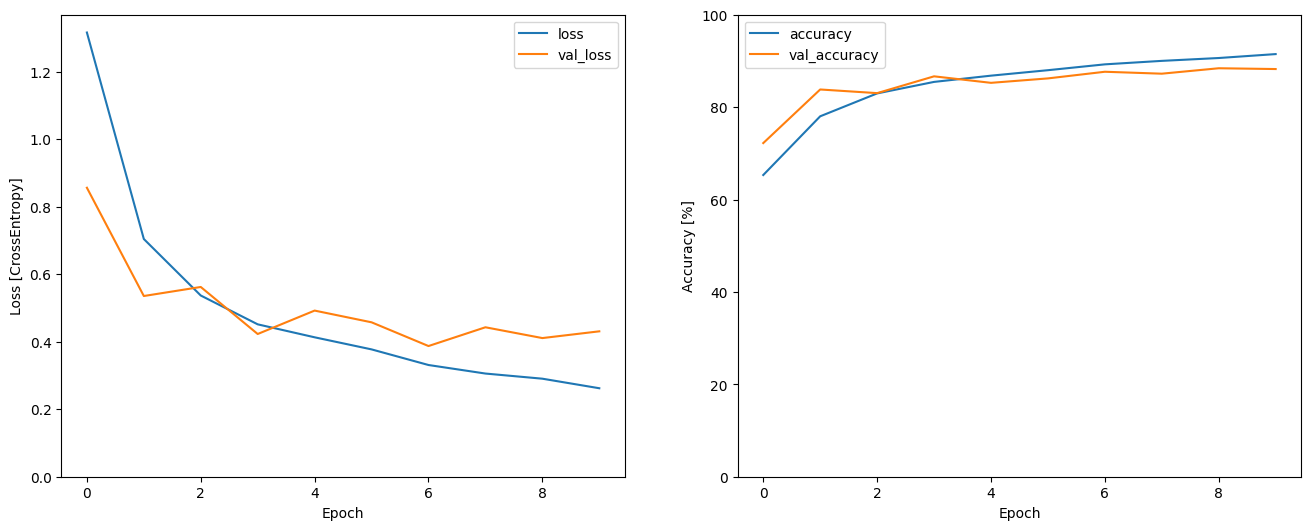

In [34]:
for history in histories:
    metrics = history.history

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')

## Evaluating the model performance

In [35]:
for model in created_models:
    model.evaluate(test_spectrogram_ds, return_dict=True)

101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8907 - loss: 0.3966

2025-01-29 17:46:33.544044: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,124,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,124,129]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-29 17:46:33.568757: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,64,62,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,62,64]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8906 - loss: 0.3969


### Displaying a confusion matrix and histogram

We'll use a confusion matrix and histogram to check how well the model did classifying each of the words in the test set:

In [36]:
def display_conf_matrix(model):
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    return confusion_mtx

In [37]:
def display_histogram(model):
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    label_mapping = {index: value for index, value in enumerate(label_names)}
    label_texts = [label_mapping[label] for label in y_pred.numpy()]
    plt.figure(figsize=(15, 8))
    sns.histplot(label_texts)
    plt.xlabel('Label')
    plt.ylabel('# of predictions')
    plt.show()

Now, we'll explore confusion matrix and histogram for all labels but unknown:

In [38]:
def display_conf_matrix_without_unknown(confusion_mtx):
    unknown_index = list(label_names).index("unknown")

    # Remove "unknown" row and column from confusion matrix
    confusion_mtx = np.delete(confusion_mtx, unknown_index, axis=0)  # Remove row
    confusion_mtx = np.delete(confusion_mtx, unknown_index, axis=1)  # Remove column

    # Remove "unknown" from label names
    filtered_labels = np.delete(label_names, unknown_index)

    # Plotting the modified confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=filtered_labels,
                yticklabels=filtered_labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()


In [39]:
def display_histogram_without_unknown(model):
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    # Create a mapping of indices to labels
    label_mapping = {index: value for index, value in enumerate(label_names)}

    # Filter out predictions with the "unknown" label
    unknown_index = list(label_mapping.values()).index("unknown")
    filtered_y_pred = [label for label in y_pred.numpy() if label != unknown_index]

    # Map the filtered predictions to their text labels
    label_texts = [label_mapping[label] for label in filtered_y_pred]

    # Plot the histogram excluding "unknown" predictions
    plt.figure(figsize=(15, 8))
    sns.histplot(label_texts)
    plt.xlabel('Label')
    plt.ylabel('# of predictions')
    plt.show()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


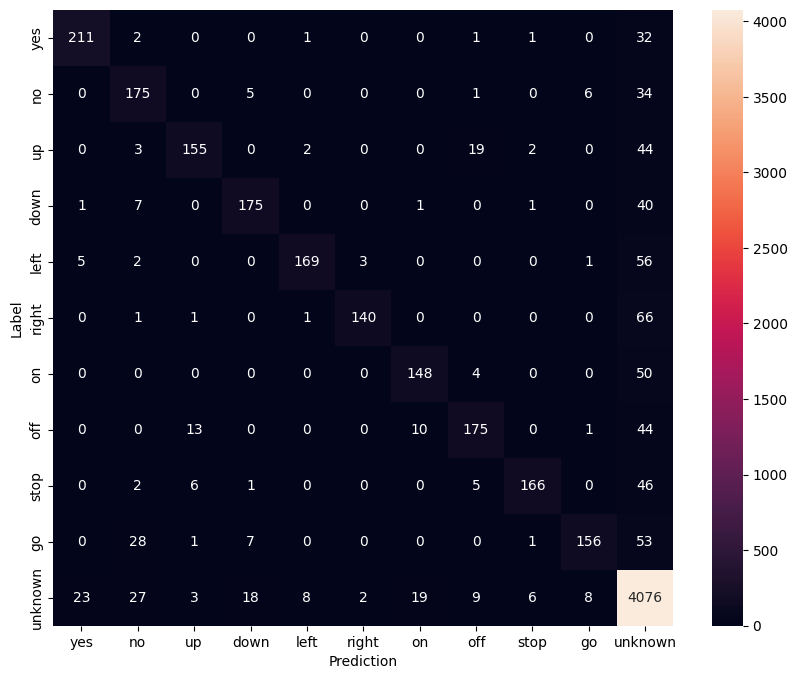

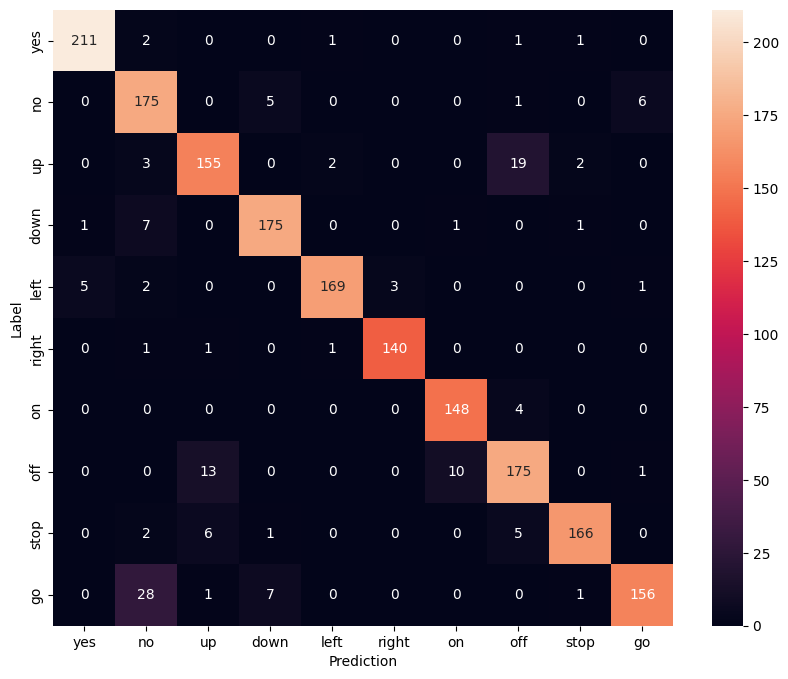

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


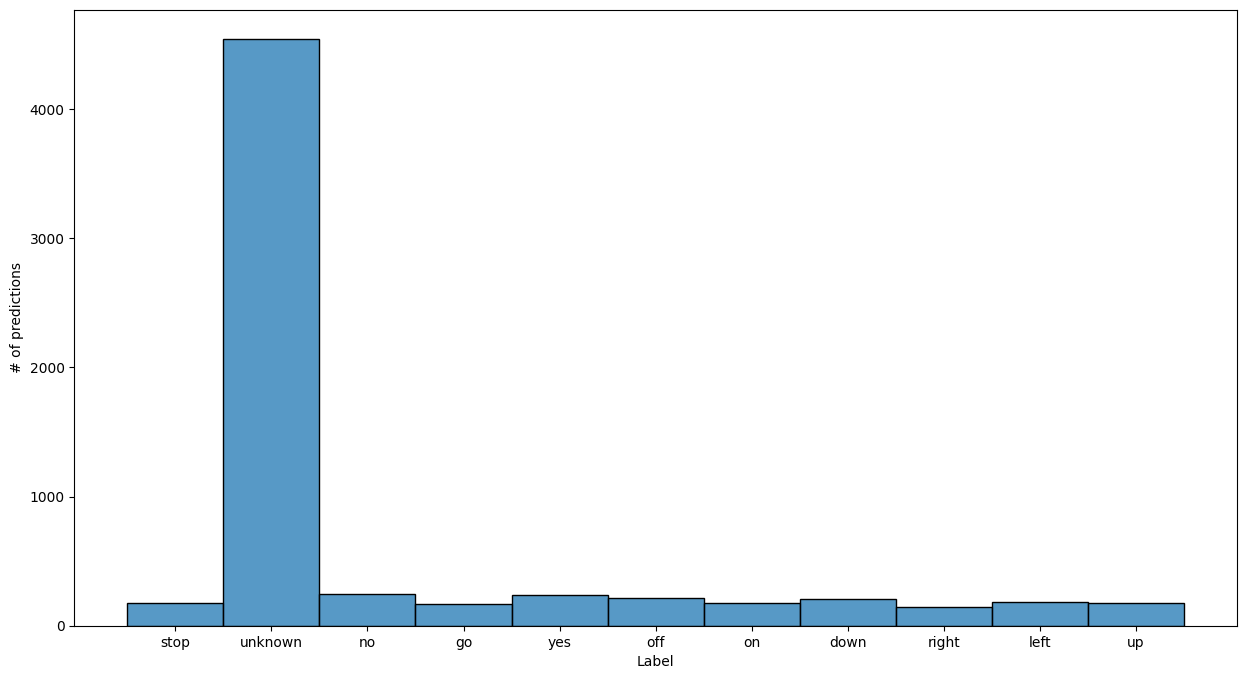

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


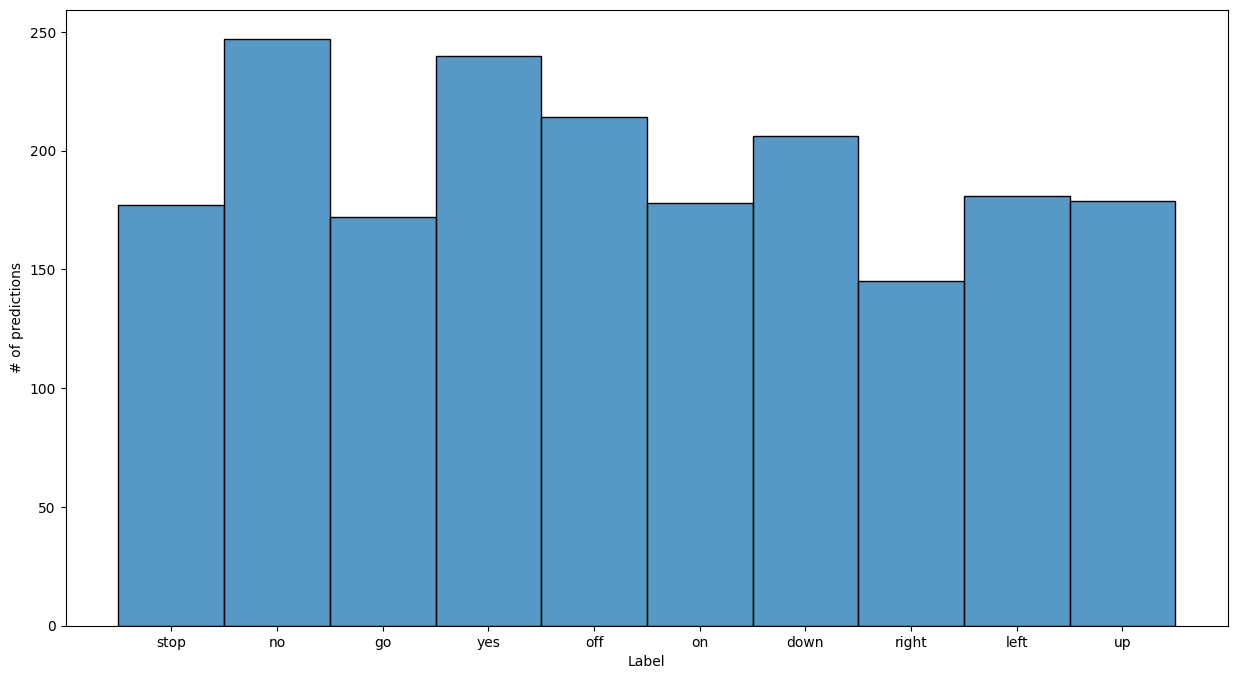

In [40]:
for model in created_models:
    confusion_matrix = display_conf_matrix(model)
    display_conf_matrix_without_unknown(confusion_matrix)
    display_histogram(model)
    display_histogram_without_unknown(model)

## Predicting labels with the model

Next, we will use our model to predict labels for the test sounds. The results, including each sound's filename and its predicted label, will be saved to a CSV file.

In [41]:
def verify_model_prediction(model):
    y_pred = model.predict(submission_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    print(y_pred)
    label_mapping = {index: value for index, value in enumerate(label_names)}
    label_texts = [label_mapping[label] for label in y_pred.numpy()]
    return label_texts

In [42]:
def plot_labels(label_texts):
    plt.figure(figsize=(15, 8))
    sns.histplot(label_texts)
    plt.xlabel('Label')
    plt.ylabel('# of predictions')
    plt.show()

In [43]:
def result_data_frame(label_texts):
    result_df = pd.DataFrame(label_texts, columns=['label'])

    file_names = sorted([path.name for path in test_dir.glob("*/*")])
    result_df["file"] = file_names

    result_df = result_df[['file', 'label']]
    result_df.to_csv('submission.csv', index=False)
    return result_df

2318/2321 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2025-01-29 17:47:01.886210: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[59,32,124,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[59,1,124,129]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-29 17:47:02.060430: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[59,64,62,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[59,32,62,64]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

2321/2321 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step
tf.Tensor([ 1 10 10 ...  8 10  8], shape=(148539,), dtype=int64)


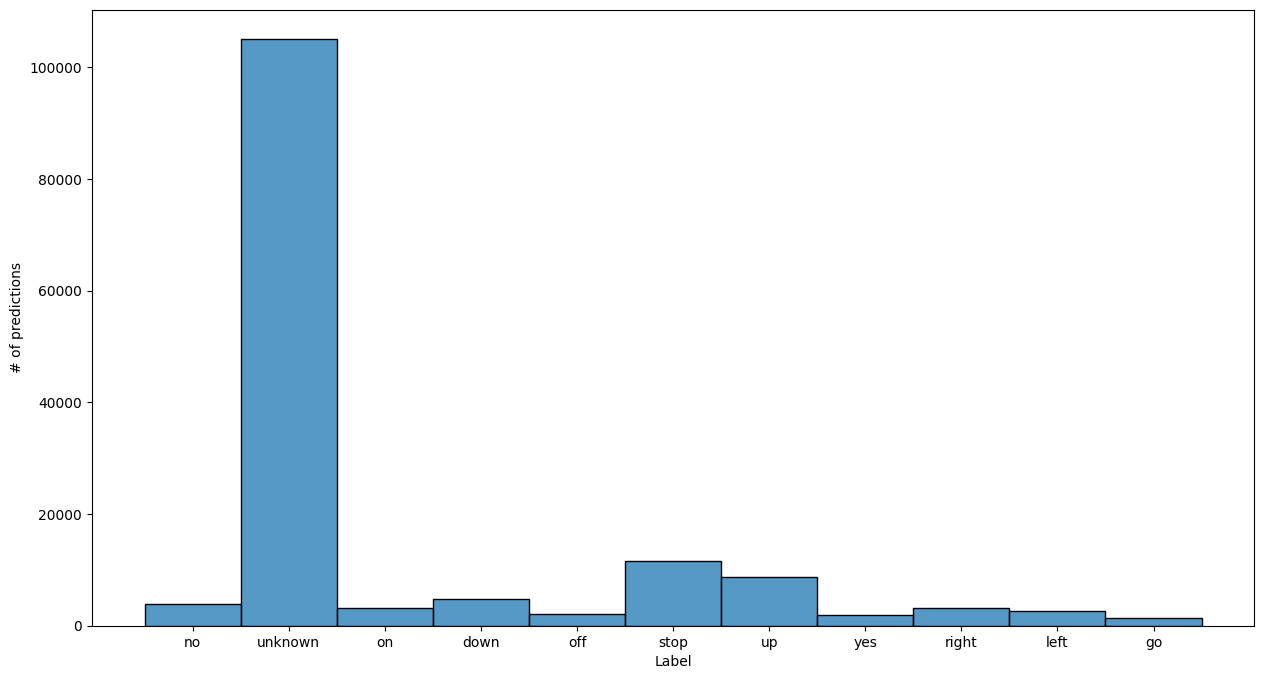

In [44]:
for model in created_models:
    label_texts = verify_model_prediction(model)
    plot_labels(label_texts)
    result_df = result_data_frame(label_texts)
    result_df

## Verification of models prediction

Let's select a sound and verify its predicted label.

In [45]:
def verify_model_prediction(model):
    x = test_dir/'audio/clip_00082a7d6.wav' 
    x = tf.io.read_file(str(x))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]

    prediction = model(x)
    plt.bar(label_names, tf.nn.softmax(prediction[0]))
    plt.show()

    display.display(display.Audio(waveform, rate=16000))

for model in created_models:
    verify_model_prediction(model)

2025-01-29 17:47:05.904139: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: test/audio/clip_00082a7d6.wav; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} test/audio/clip_00082a7d6.wav; No such file or directory [Op:ReadFile]

In [50]:
# for model, func in zip(created_models, sweep_config["parameters"]["activation_function"]["values"]):
#     model.save(f'models/dp_complex_0.3_lr_0.001_af_{func}_SGD_epochs_10_noise_set.h5')

: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Visualizing conv1 output shape: (1, 124, 129, 32)


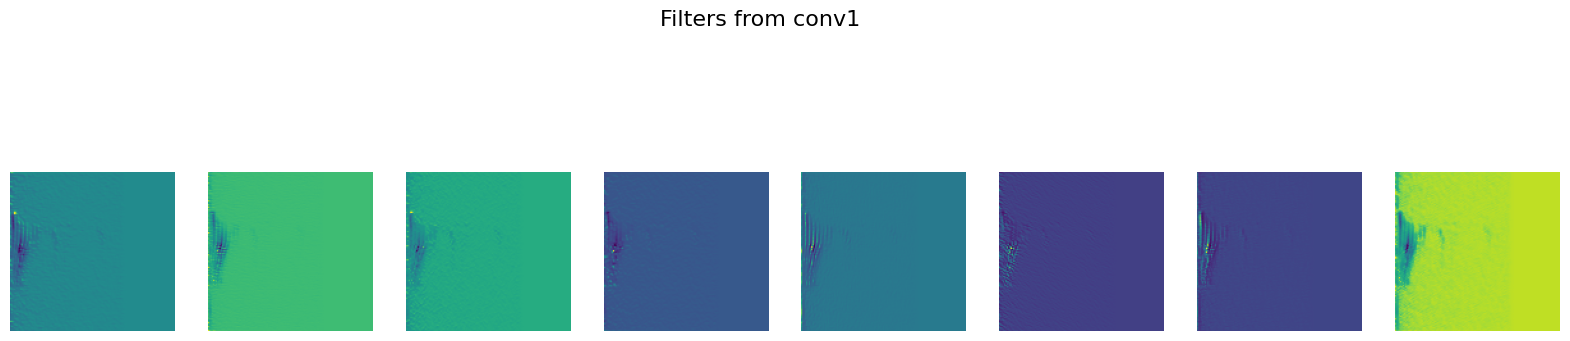

Visualizing conv2 output shape: (1, 62, 64, 64)


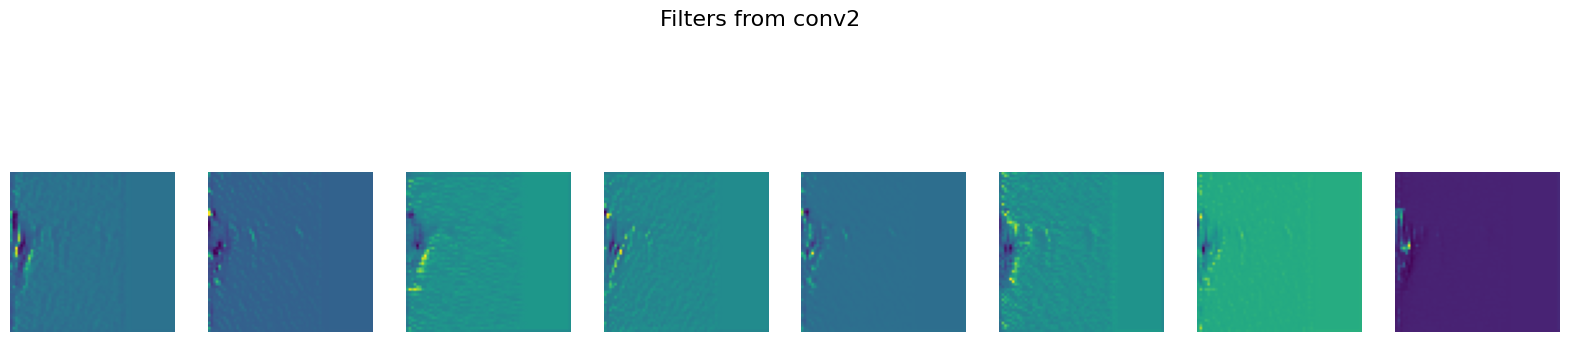

Visualizing conv3 output shape: (1, 31, 32, 128)


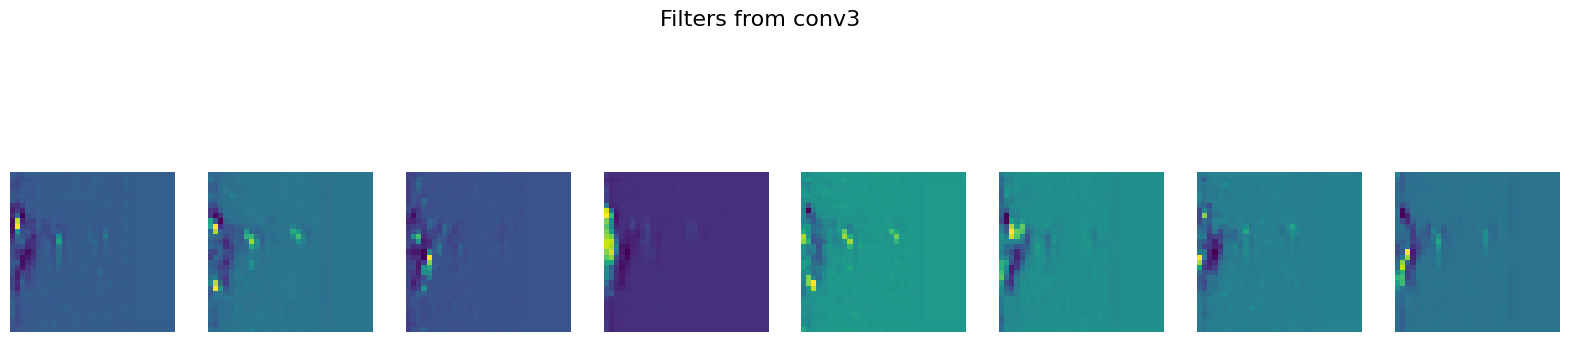

conv1 - filter shape: (3, 3, 1, 32)


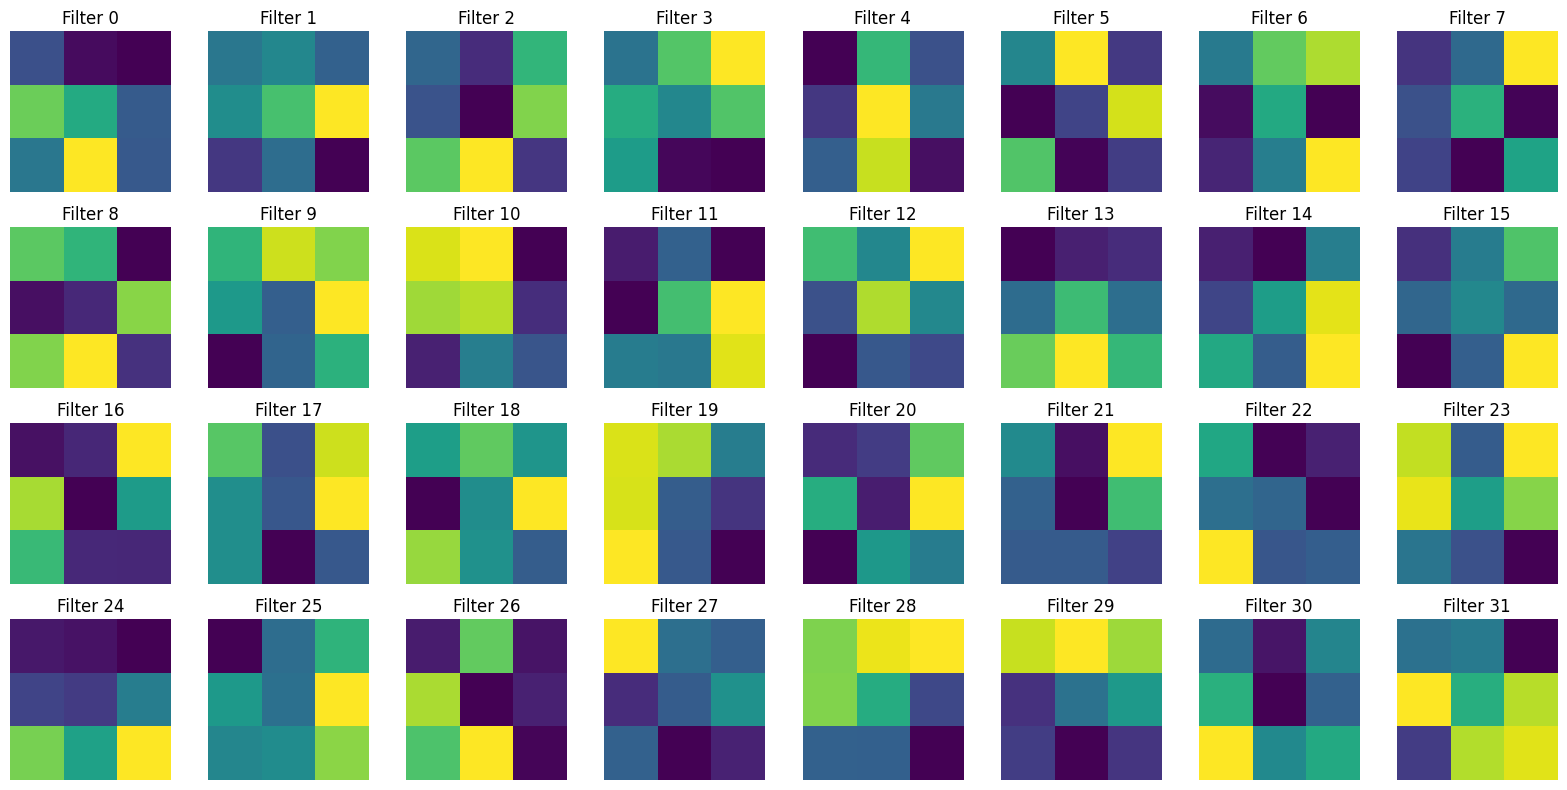

conv2 - filter shape: (3, 3, 32, 64)


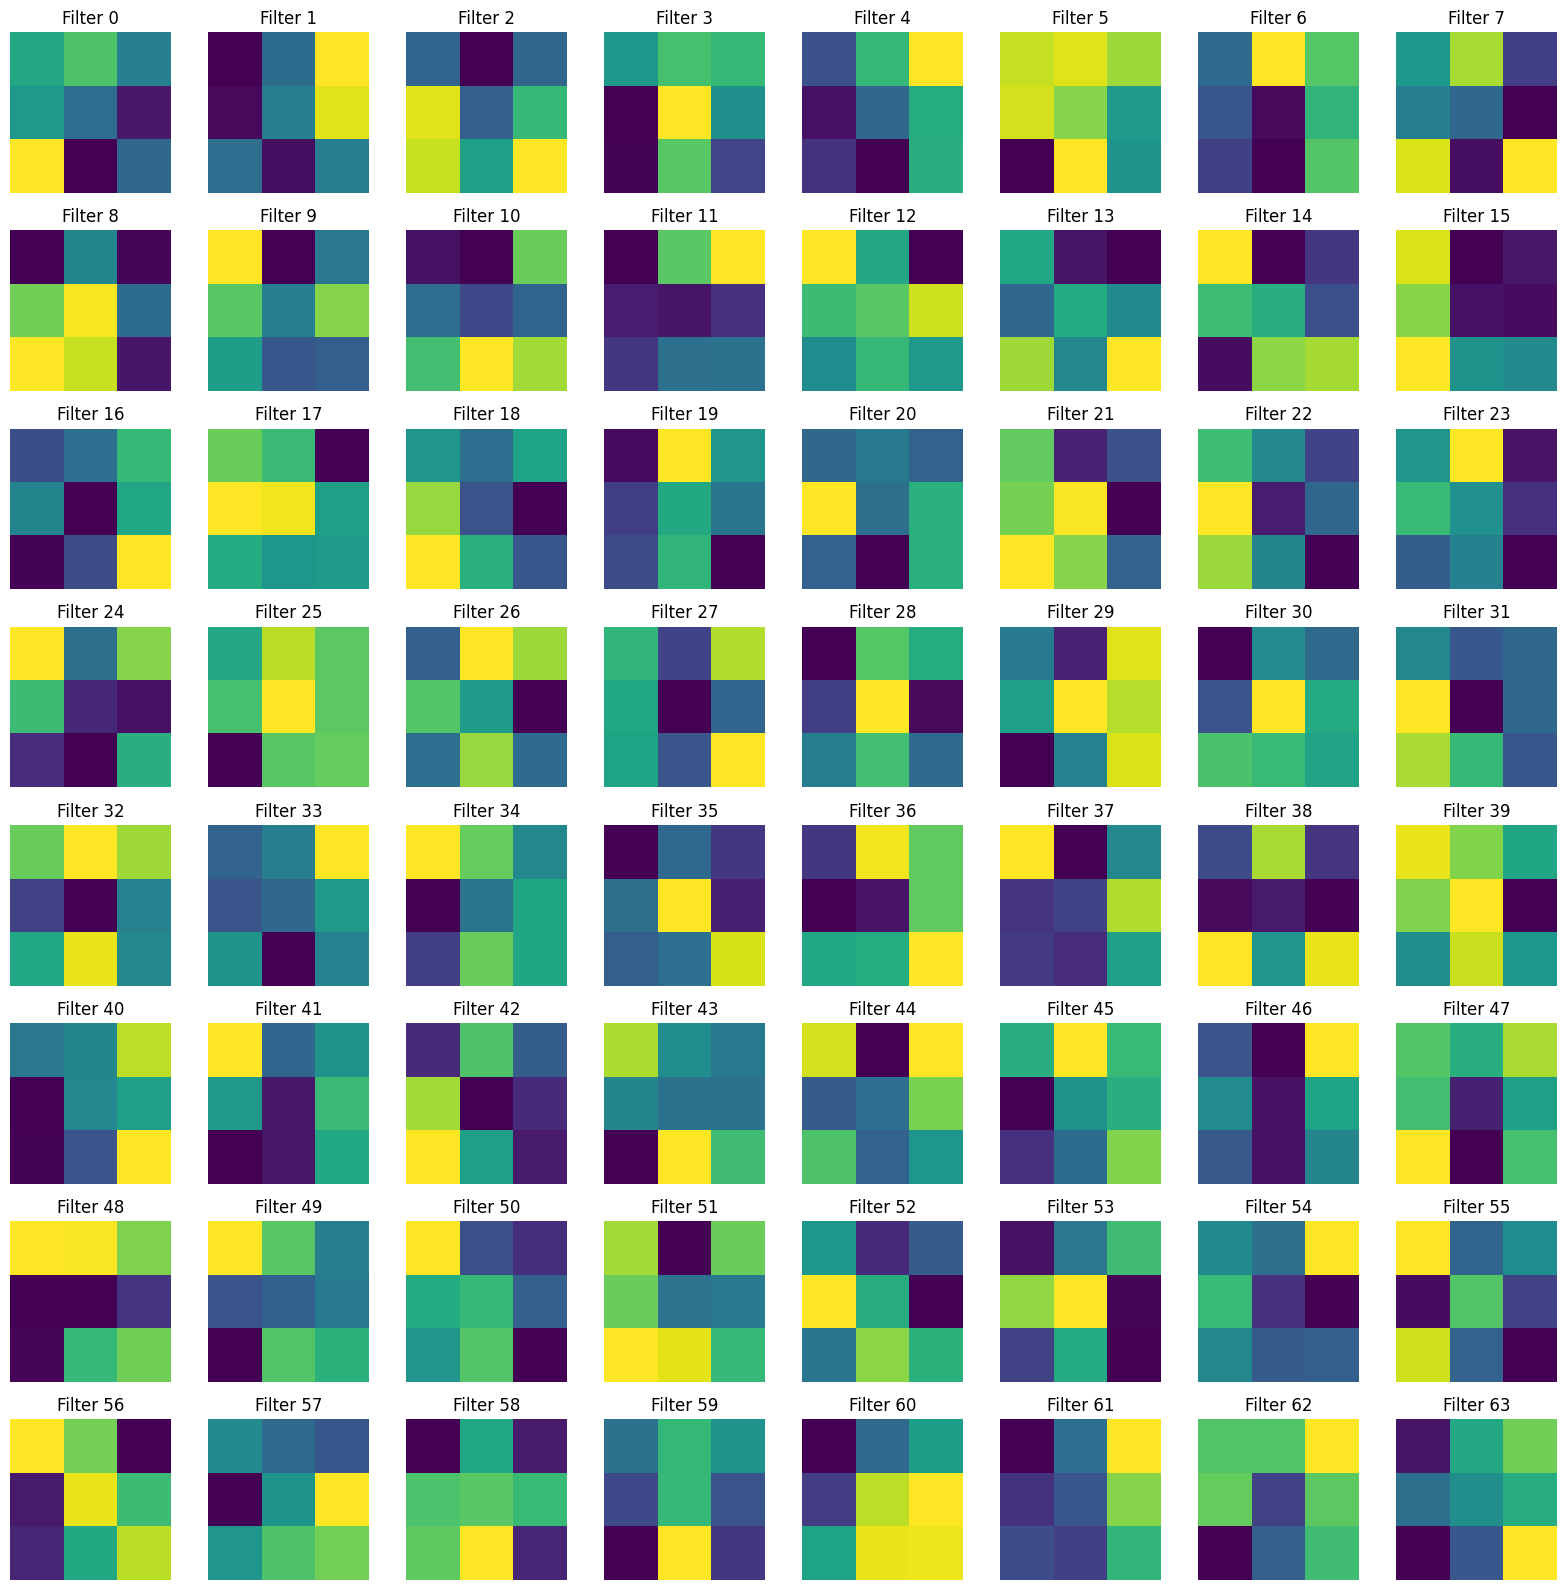

conv3 - filter shape: (3, 3, 64, 128)


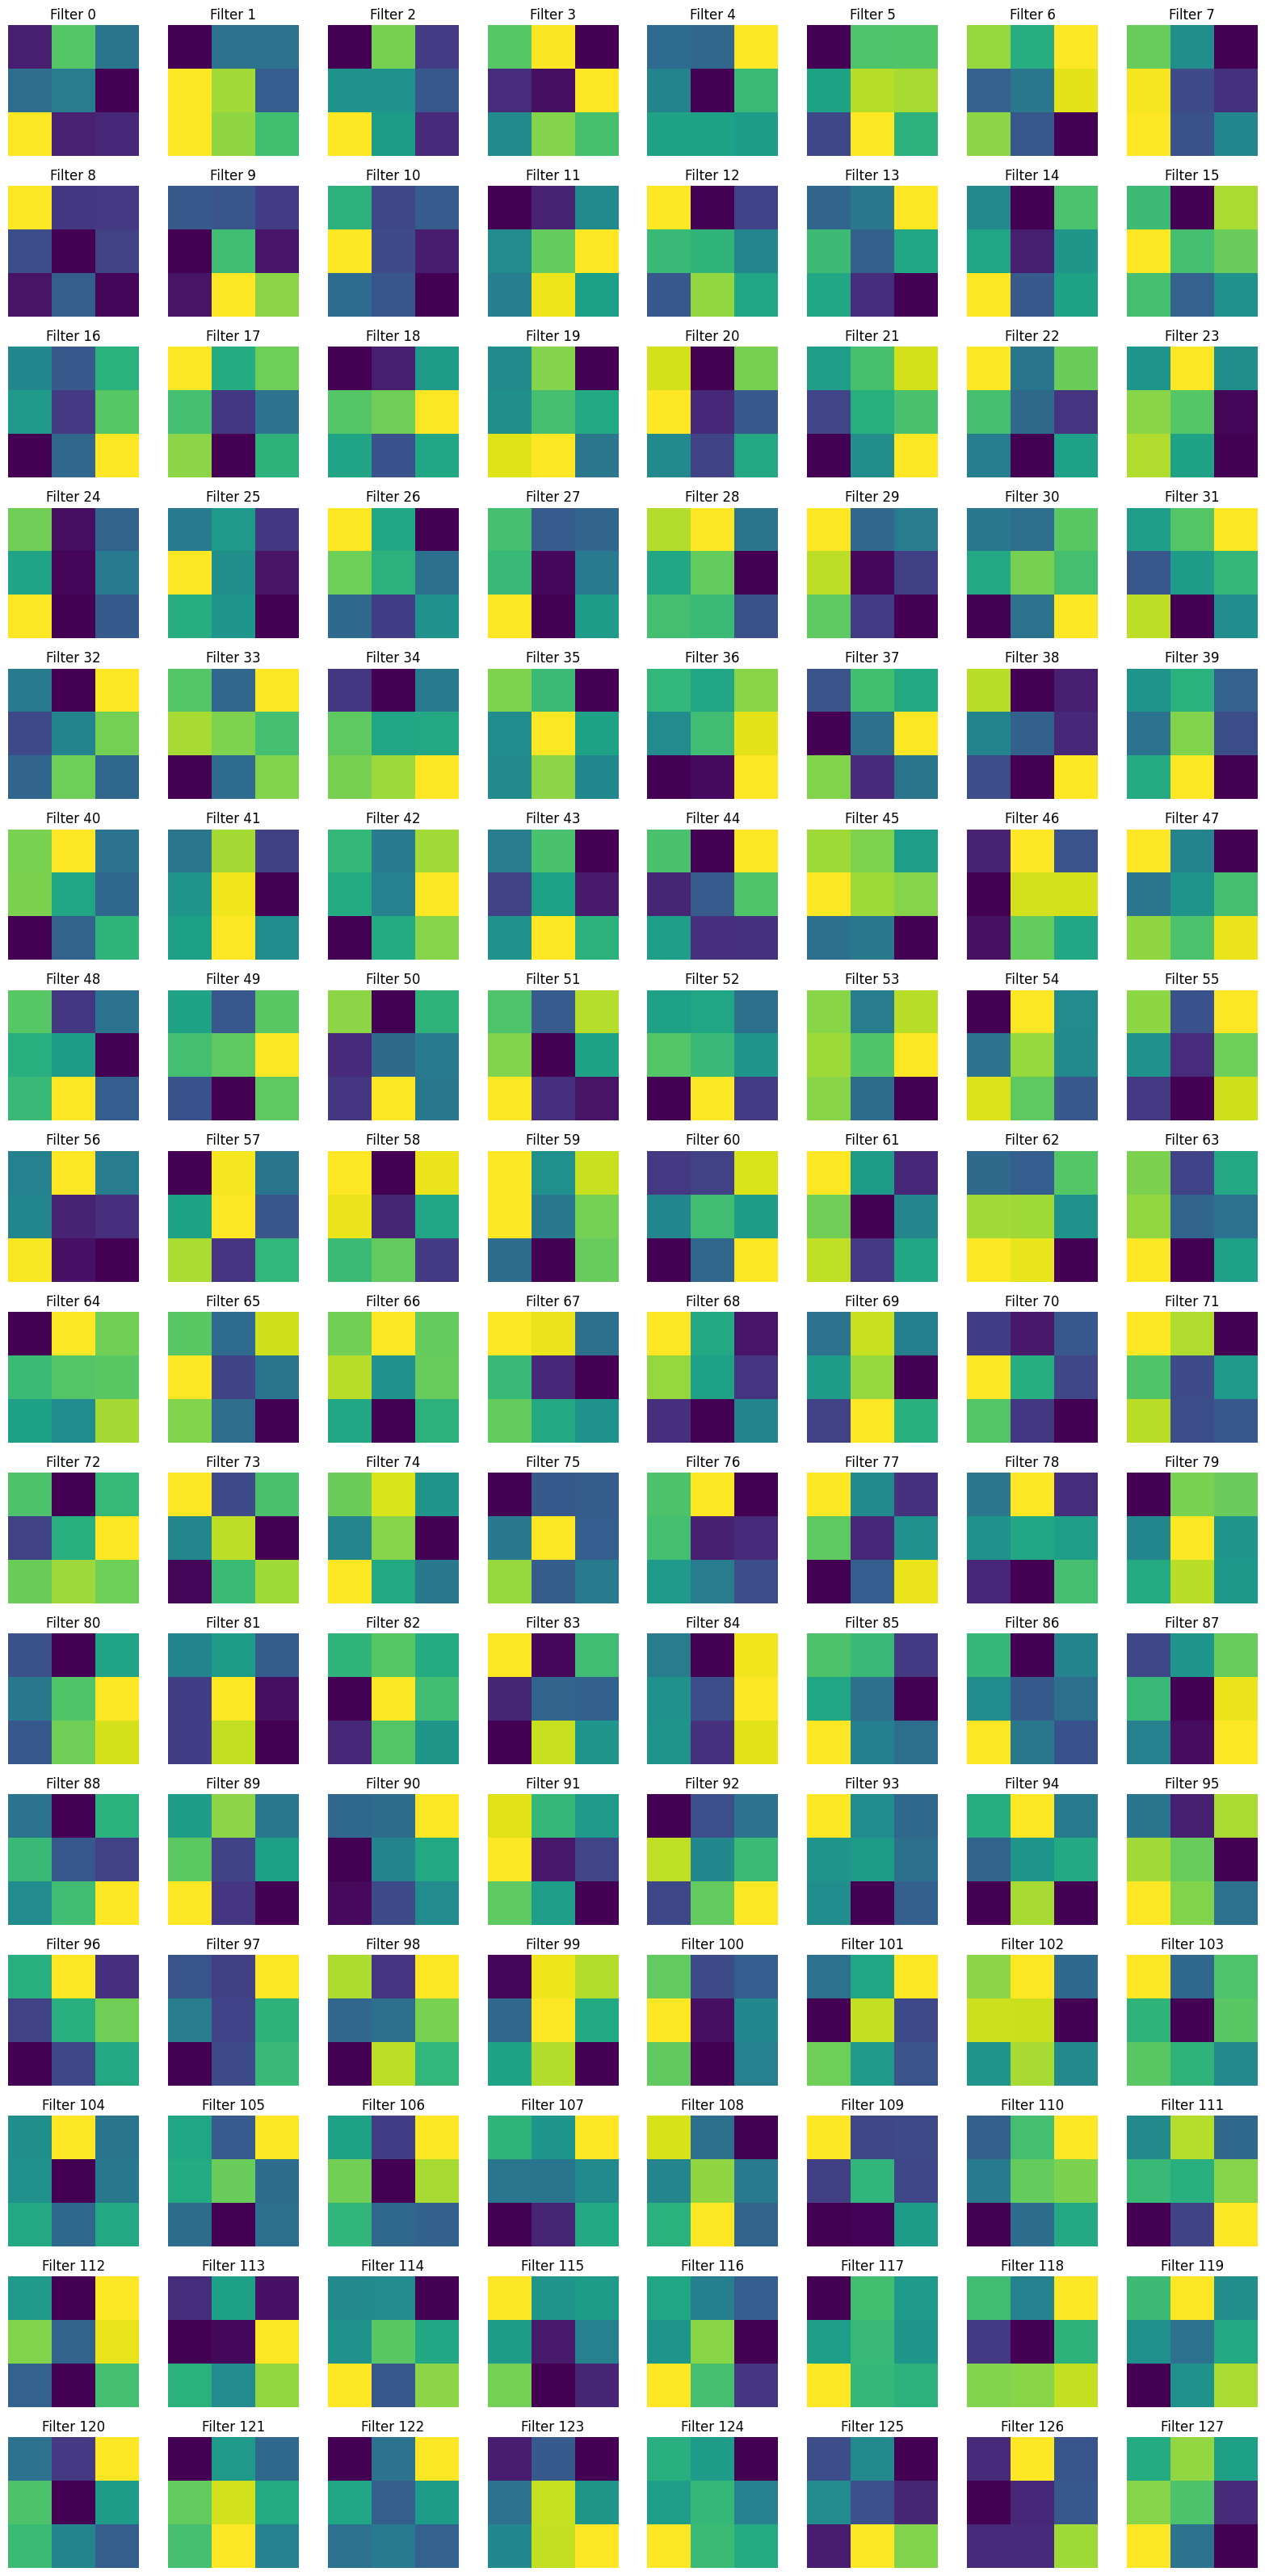

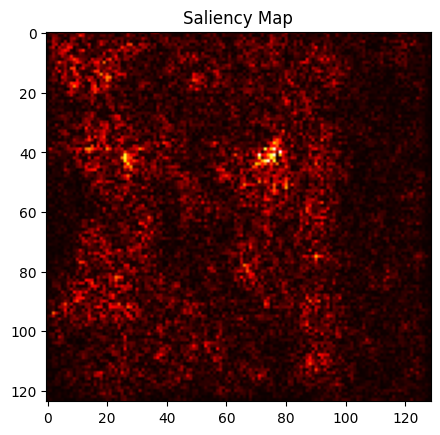

In [46]:

# Define a function to visualize intermediate layer outputs
def visualize_layer_outputs(model, input_data, layer_names=None):
    if layer_names is None:
        # Default to all convolutional layers
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

    # Ensure the model is built by calling it with a samprint("Model layers:", model.layers)
    model.build(input_shape=(None, 124, 129, 1))  # Use your input shape here

    input_data = tf.expand_dims(input_data[0], axis=0)  # Add batch dimension
    model(input_data)  # This ensures the model is built and the layers are initialized

    # Create a new model that outputs the activations of the specified layers
    intermediate_model = models.Model(inputs=model.layers[0].input, 
                                               outputs=[model.get_layer(name).output for name in layer_names])

    # Pass the input data through the intermediate model
    intermediate_outputs = intermediate_model.predict(input_data)

    # Plot the outputs
    for layer_name, layer_output in zip(layer_names, intermediate_outputs):
        print(f"Visualizing {layer_name} output shape: {layer_output.shape}")
        num_filters = layer_output.shape[-1]
        size = layer_output.shape[1]

        # Create a grid of filter outputs
        fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(20, 5))
        for i, ax in enumerate(axes):
            if i >= num_filters:
                break
            ax.imshow(layer_output[0, :, :, i], cmap='viridis')
            ax.axis('off')
        plt.suptitle(f"Filters from {layer_name}", fontsize=16)
        plt.show()

def visualize_filters(model, layer_name, num_columns=8):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    print(f"{layer_name} - filter shape: {filters.shape}")

    # Normalize filter values to 0-1 for visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # Number of filters
    num_filters = filters.shape[-1]
    
    # Calculate number of rows needed for the grid
    num_rows = int(np.ceil(num_filters / num_columns))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    # Plot filters
    for i in range(num_filters):
        f = filters[:, :, :, i]
        ax = axes[i]
        ax.imshow(f[:, :, 0], cmap='viridis')
        ax.set_title(f"Filter {i}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_filters, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def compute_saliency_map(model, input_data, class_index):
    input_data = tf.convert_to_tensor(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
        loss = predictions[:, class_index]

    gradients = tape.gradient(loss, input_data)
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency[0]

# Example usage
for model in created_models:
    for example_spectrogram, label in train_spectrogram_ds.take(1):
        visualize_layer_outputs(model, example_spectrogram)  # Add batch dimension
        visualize_filters(model, 'conv1')
        visualize_filters(model, 'conv2')
        visualize_filters(model, 'conv3')
        saliency_map = compute_saliency_map(model, example_spectrogram, label[0])
        plt.imshow(saliency_map, cmap='hot')
        plt.title("Saliency Map")
        plt.show()